In [31]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [32]:
# Takes 6 minutes to load the data if this is your first time
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
k=1
pca = PCA(n_components=k, svd_solver='full').fit(X_scaled)
eigenfaces_pca = pca.components_.reshape((k, h, w))
spca = SparsePCA(n_components=k, alpha=0.1, ridge_alpha=0).fit(X_scaled)
eigenfaces_spca = spca.components_.reshape((k, h, w))

In [36]:
def spca_exp(X_scaled,k):
    alpha_vals=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.10, 0.20, 0.50, 1.0, 2.0, 5.0]
    ridge_alpha=0.0

    best_spca_alpha=0.0
    best_spca_alpha_err=math.inf
    for idx in range(len(alpha_vals)):
        alpha=alpha_vals[idx]
        spca = SparsePCA(n_components=k, ridge_alpha=ridge_alpha, alpha=alpha).fit(X_scaled)
        X_reduced = spca.transform(X_scaled)
        X_recon = spca.inverse_transform(X_reduced)
        spca_err=mean_squared_error(X_scaled, X_recon)
        print("alpha=",alpha,"err=",spca_err)
        if spca_err < best_spca_alpha_err:
            best_spca_alpha_err=spca_err
            best_spca_alpha=alpha
            best_eigenfaces_spca = spca.components_.reshape((k,h,w))
    
    print("\n\nBest SPCA:")
    print("- alpha:",best_spca_alpha)
    print("- err:",best_spca_alpha_err)
    
    return best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca

In [37]:
best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca = spca_exp(X_scaled,k)

alpha= 0.001 err= 0.022270383
alpha= 0.002 err= 0.022270383
alpha= 0.005 err= 0.022270385
alpha= 0.01 err= 0.02227039
alpha= 0.02 err= 0.022270408
alpha= 0.05 err= 0.02227057
alpha= 0.1 err= 0.02227117
alpha= 0.2 err= 0.022273978
alpha= 0.5 err= 0.02230394
alpha= 1.0 err= 0.022681747
alpha= 2.0 err= 0.023934437
alpha= 5.0 err= 0.028316248


Best SPCA:
- alpha: 0.001
- err: 0.022270383


In [38]:
def kernel_exp(X_scaled,k):

    lin_pca = KernelPCA(n_components = k, kernel="linear", fit_inverse_transform=True)
    rbf_pca = KernelPCA(n_components = k, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
    sig_pca = KernelPCA(n_components = k, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

    kernel_options=((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"))

    best_kernel=""
    best_kernel_err=math.inf
    for subplot, pca, title in kernel_options:
        X_reduced = pca.fit_transform(X_scaled)
        X_recon = pca.inverse_transform(X_reduced)
        err=mean_squared_error(X_scaled, X_recon)
        print("Kernel PCA (",title,") MSE reconstruction loss:",err)
        if err < best_kernel_err:
            best_kernel=title
            best_kernel_err=err
            best_eigenfaces_kernel = pca.eigenvectors_.reshape((k,h,w))
            print("- New best kernel")

    print("\n\nBest MSE reconstruction error:",best_kernel_err)
    print("- Kernel:",best_kernel)
    
    return best_kernel, best_kernel_err, best_eigenfaces_kernel

In [39]:
best_kernel, best_kernel_err, best_eigenfaces_kernel = kernel_exp(X_scaled,k)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.29385805


ValueError: ignored

In [40]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(1):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

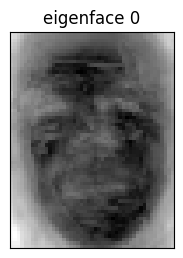

In [42]:
eigenface_titles = [f"eigenface {i}" for i in range(best_eigenfaces_spca.shape[0])]
plot_gallery(best_eigenfaces_spca, eigenface_titles, h, w)

plt.show()

In [ ]:
eigenface_titles = [f"eigenface {i}" for i in range(best_eigenfaces_spca[0])]
plot_gallery(best_eigenfaces_kernel, eigenface_titles, h, w)

plt.show()
